In [4]:
from scripts.preprocessing import load_ztf_data,kernel_smoothing
from scripts.plot import plot_light_curve
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import sys
from sklearn.preprocessing import LabelEncoder 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from collections import defaultdict
from IPython.display import Image
from sklearn.model_selection import train_test_split

### Leemos el dataset

In [5]:
lcs,periods,labels = load_ztf_data("raw_data/lcdata.pbz2")

le = LabelEncoder()
labels_int = le.fit_transform(labels)

### Vemos una curva de luz cruda

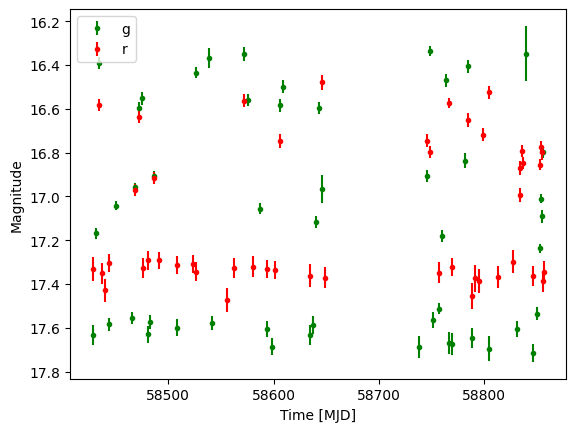

In [6]:
idx = 7
plot_light_curve(lcs[idx],periods[idx])

### Vemos una curva de luz doblada

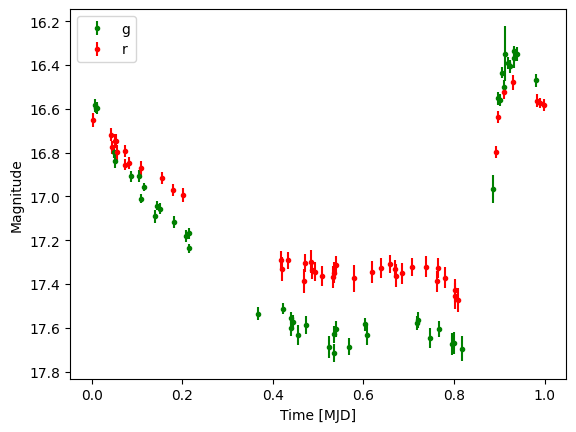

In [7]:
idx = 7
plot_light_curve(lcs[idx],periods[idx],fold=True)

#### Observamos las clases de estrellas disponibles en el dataset y el comportamiento de las curvas de luz dobladas de algunos ejemplos aleatorios

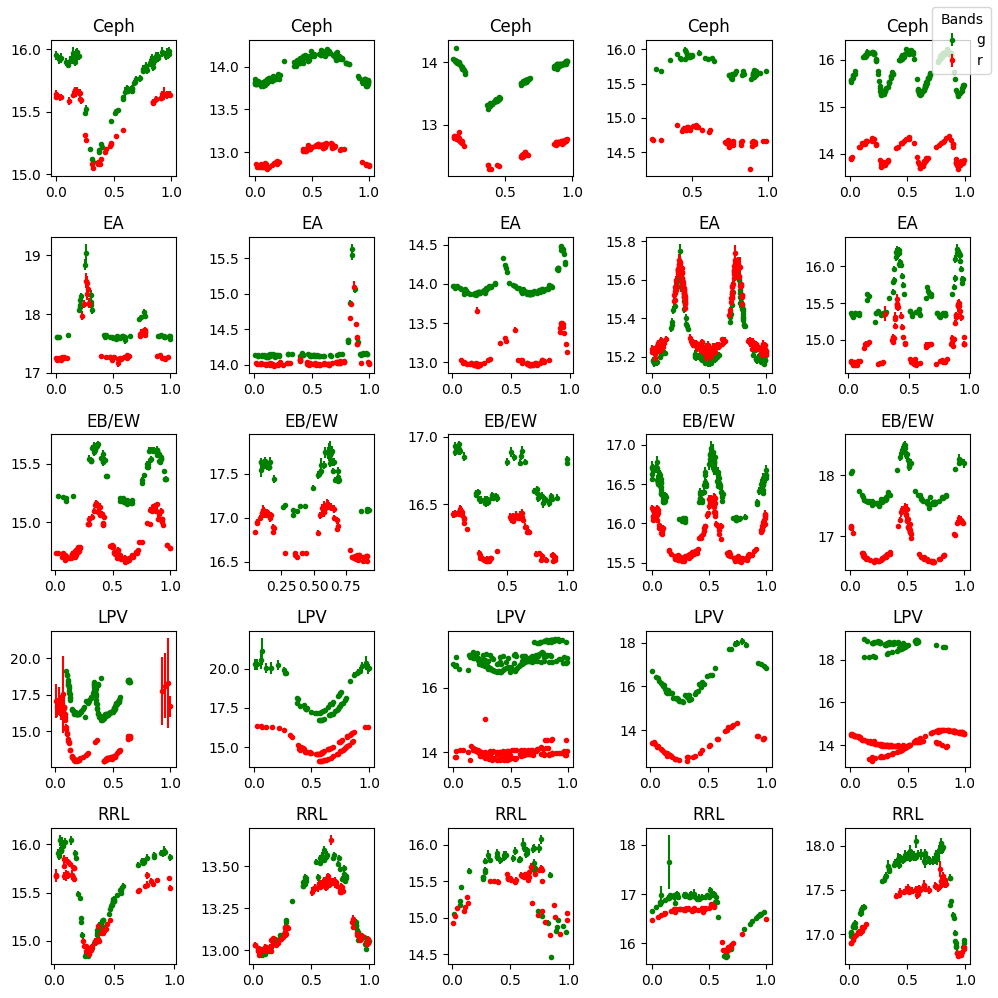

In [8]:
labels = np.array(labels) 
unique_classes = np.unique(labels)

samples_per_class = defaultdict(list)

for cls in unique_classes:
    indices = np.where(labels == cls)[0]
    selected = np.random.choice(indices, size=5, replace=False)
    samples_per_class[cls] = selected.tolist()

fig, axs = plt.subplots(5, 5, tight_layout=True, figsize=(10, 10))

for row_index, (cls, indices) in enumerate(samples_per_class.items()):
    for idx, ax in zip(indices, axs[row_index].ravel()):
        mjds, mags, errs, bands = lcs[idx]
        period = periods[idx]
        for band, band_name in zip(np.unique(bands), ['g', 'r']):
            mask = bands == band
            mjd = mjds[mask]
            mag = mags[mask]
            err = errs[mask]
            phase = np.mod(mjd, period) / period
            ax.errorbar(phase, mag, err, fmt=".", label=band_name, c=band_name)
        ax.set_title(cls)

handles, labels_ = axs.flat[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc='upper right', title="Bands", fontsize=10)

### Preparamos los datos para el modelo

- Las curvas de luz al ser series de tiempo irregulares, pueden tener diferentes longitudes y no estar alineadas en el tiempo entre si
- Para poder entrenar un modelo de redes neuronales, necesitamos que todas las curvas de luz tengan la misma longitud y estén alineadas en el tiempo
#### Ejemplo:

In [9]:
idx = 619
phase_interpolate = np.linspace(0,1,num=40) #Definimos una grilla regular de observaciones y la llevamos al rango 0 a 1.

#### ¿Cómo podemos hacer de algo irregular algo regular?  
- Podemos usar interpolación para poder tener una observación en cualquier instante de tiempo y si tenemos definido una grilla regular de tiempo para todas las curvas de luz, podemos interpolar cada curva de luz a esa grilla regular.

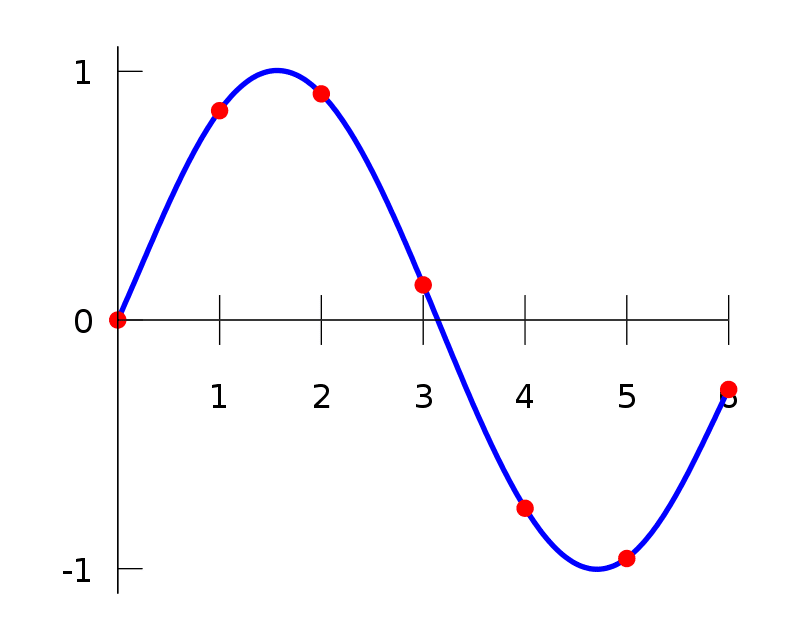

In [10]:
Image("images/interpolation_example.png")

- Llamamos a una función que interpola la curva de luz con métodos ....

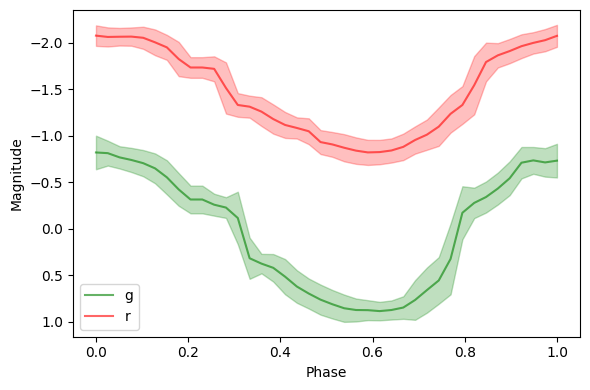

In [11]:
from scripts.plot import plot_smoothed_matplotlib
mag_int ,err_int,_ = kernel_smoothing(lcs[idx],periods[idx],phase_interpolate)
plot_smoothed_matplotlib(phase_interpolate,mag_int,err_int)

- Ahora tenemos una forma de hacer una curva de luz regular. Debemos aplicar este procesamiento a todas las curvas de luz del dataset.

In [12]:
phase_int = np.linspace(0,1,num=40)
mag_int = np.zeros(shape=(len(lcs),2,len(phase_int))) #curva,banda,observacion
err_int = np.zeros(shape=(len(lcs),2,len(phase_int))) 

for k,(lc,period) in enumerate(zip(lcs,periods)):
    mag_int[k],err_int[k],_ = kernel_smoothing(lc,period,phase_int)

Ahora que el dataset está listo, podemos definir el modelo de red neuronal

In [13]:
class Autoencoder(nn.Module):
    def __init__(self,
                 input_dim:int = 40,
                 latent_dim:int = 2):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,(input_dim//3)*2),
            nn.ReLU(),
            nn.Linear((input_dim//3)*2,(input_dim//3)),
            nn.ReLU(),
            nn.Linear((input_dim//3),latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, (input_dim // 3)),
            nn.ReLU(),
            nn.Linear((input_dim // 3), (input_dim // 3) * 2),
            nn.ReLU(),
            nn.Linear((input_dim // 3) * 2, input_dim)
        )
    def forward(self,x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

### Alguien nota algo extraño en la definición del modelo?

#### Extraemos las magnitudes y errores luego de interpolar las curvas de luz para cada banda

In [14]:
mag_g = mag_int[:, 0, :]
mag_r = mag_int[:, 1, :]

err_g = err_int[:, 0, :]
err_r = err_int[:, 1, :]

#### Creamos la clase que permite manejar estos datos

In [15]:
class OneBandDataset(Dataset):
    def __init__(self, mags, errors):
        self.mags = torch.tensor(mags, dtype=torch.float32)
        self.errors = torch.tensor(errors, dtype=torch.float32)

    def __len__(self):
        return len(self.mags)

    def __getitem__(self, idx):
        return {
            'mag': self.mags[idx],
            'err': self.errors[idx]
        }


#### Definimos datos de entrenamiento y validación

In [16]:
mag_g_train,mag_g_test,err_g_train,err_g_test = train_test_split(mag_g,err_g,test_size=0.2,stratify=labels_int)
mag_r_train,mag_r_test,err_r_train,err_r_test = train_test_split(mag_r,err_r,test_size=0.2,stratify=labels_int)

train_dataset_g = OneBandDataset(mag_g_train, err_g_train)
test_dataset_g  = OneBandDataset(mag_g_test, err_g_test)

train_dataset_r = OneBandDataset(mag_r_train, err_r_train)
test_dataset_r  = OneBandDataset(mag_r_test, err_r_test)

#### Creamos los dataloaders para el entrenamiento de ambos modelos

In [17]:
train_loader_g = DataLoader(train_dataset_g, batch_size=64, shuffle=True)
test_loader_g  = DataLoader(test_dataset_g, batch_size=64, shuffle=False)

train_loader_r = DataLoader(train_dataset_r, batch_size=64, shuffle=True)
test_loader_r  = DataLoader(test_dataset_r, batch_size=64, shuffle=False)

#### Definimos la función de entrenamiento

In [18]:
def train(model, train_loader, test_loader, epochs=50, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        total_loss = 0.0
        for batch in train_loader:
            x = batch['mag']
            err = batch['err']
            optimizer.zero_grad()
            x_hat = model(x)
            weight = 1. / (err**2 + 1e-6)
            loss = ((x - x_hat) ** 2 * weight).mean()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
    
        model.eval()
        with torch.no_grad():
            total_test_loss = 0.0
            for batch in test_loader:
                x = batch['mag']
                err = batch['err']
                x_hat = model(x)
                weight = 1. / (err**2 + 1e-6)
                loss = ((x - x_hat) ** 2 * weight).mean()
                total_test_loss += loss.item()
            test_losses.append(total_test_loss / len(test_loader))
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Weighted MSE Loss")
    plt.title("Autoencoder Training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### Entrenamos...

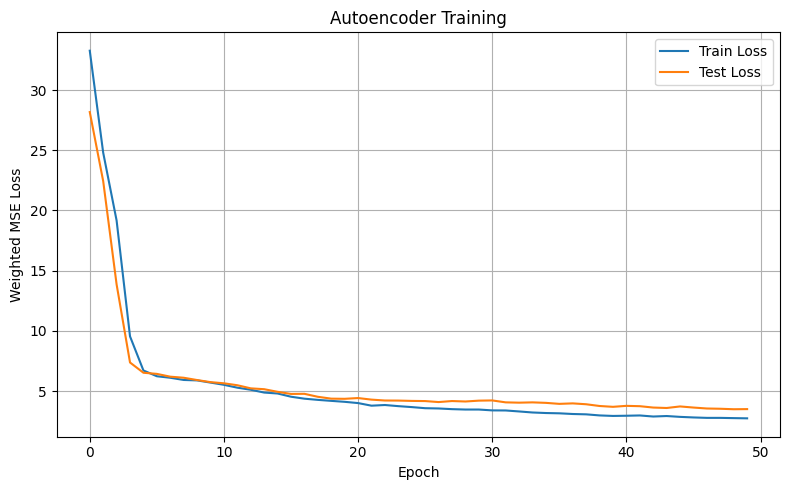

In [19]:
model_g = Autoencoder()
train(model_g,train_loader_g,test_loader_g)

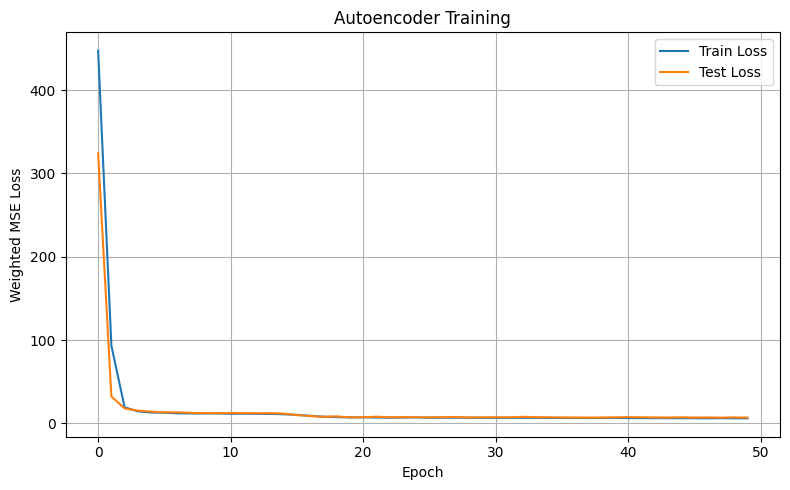

In [20]:
model_r = Autoencoder()
train(model_r,train_loader_r,test_loader_r)

#### Definimos funciones para visualizar el espacio latente para ambos modelos

In [21]:
def get_latents_and_recon(model, dataloader):
    model.eval()
    all_latents = []
    all_recon = []
    with torch.no_grad():
        for batch in dataloader:
            x = batch['mag']
            z = model.encoder(x)
            x_hat = model.decoder(z)
            all_latents.append(z)
            all_recon.append(x_hat)
    return torch.cat(all_latents), torch.cat(all_recon)
def plot_latent_space(z, labels, class_names=None, title="Latent Space"):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, alpha=0.7)
    if class_names is not None:
        legend_elements = scatter.legend_elements()[0]
        plt.legend(legend_elements, class_names, title="Class", loc="best", fontsize=10)
    plt.title(title)
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
full_dataset_g = OneBandDataset(mag_g, err_g)
full_loader_g = DataLoader(full_dataset_g, batch_size=64, shuffle=False)

z_g, recon_g = get_latents_and_recon(model_g, full_loader_g)

#### Revisamos el espacio latente de ambos modelos

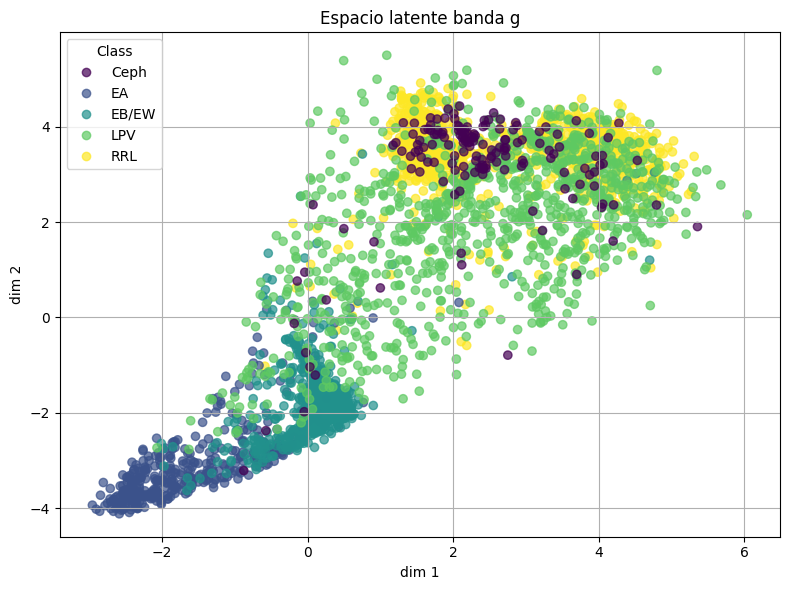

In [23]:
plot_latent_space(z_g.numpy(), labels_int, class_names=le.classes_, title="Espacio latente banda g")

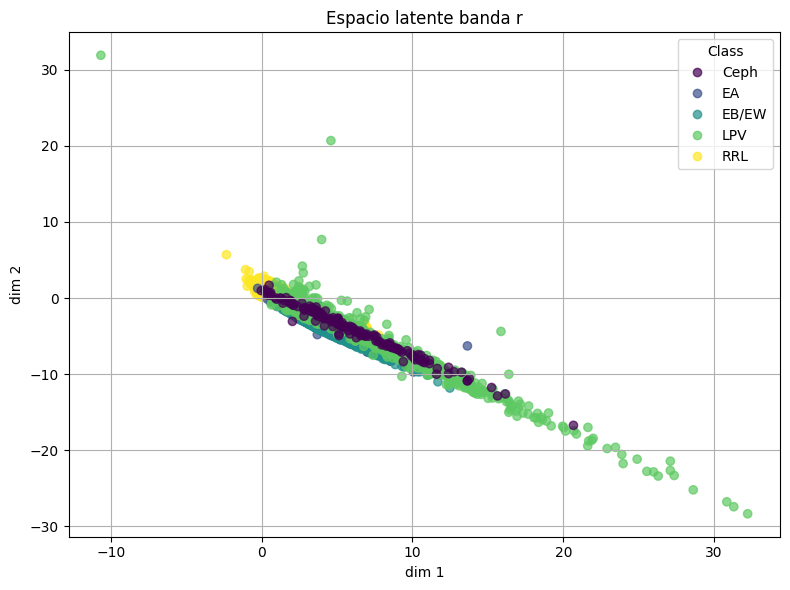

In [24]:
full_dataset_r = OneBandDataset(mag_r, err_r)
full_loader_r = DataLoader(full_dataset_r, batch_size=64, shuffle=False)
z_r,recon_r = get_latents_and_recon(model_r,full_loader_r)
plot_latent_space(z_r.numpy(),labels_int,class_names=le.classes_,title="Espacio latente banda r")

#### Evaluamos las reconstrucciones de ambos modelos

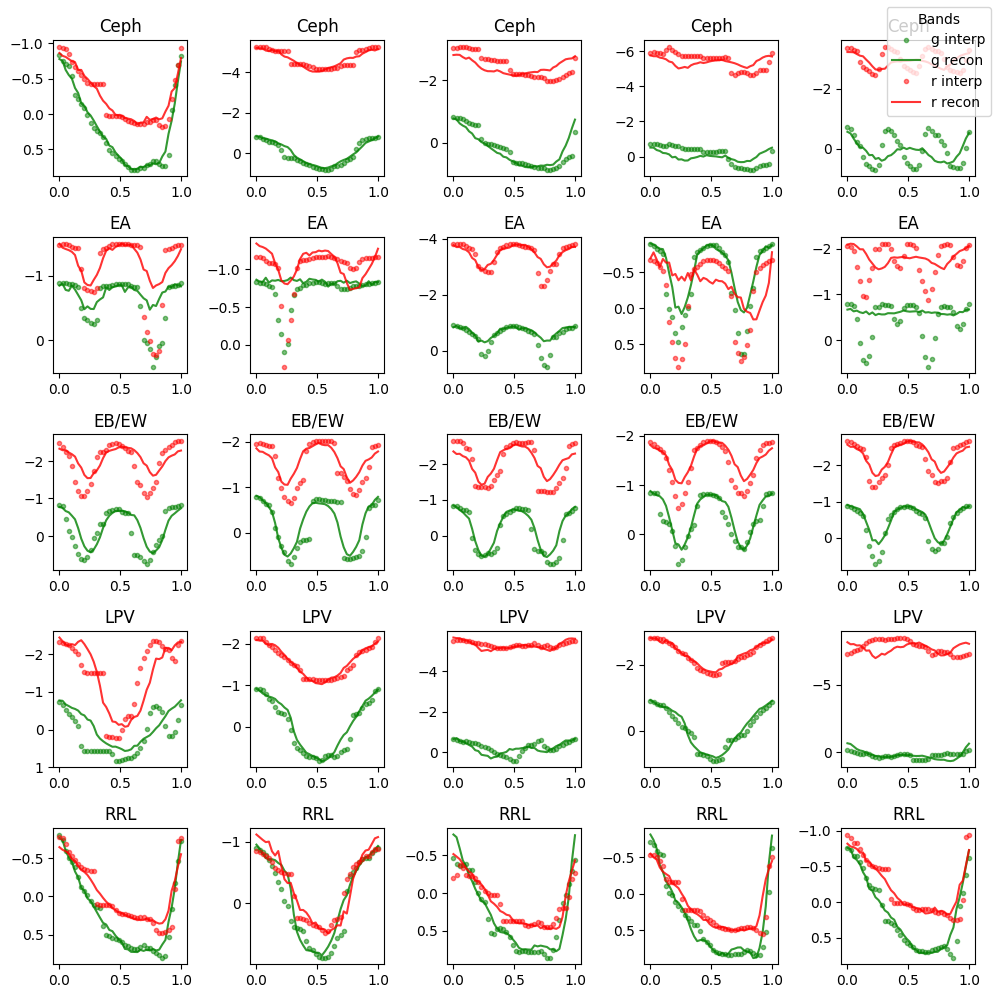

In [25]:
fig, axs = plt.subplots(5, 5, tight_layout=True, figsize=(10, 10))

for row_index, (cls, indices) in enumerate(samples_per_class.items()):
    for idx, ax in zip(indices, axs[row_index].ravel()):
        pha = phase_int
        mag_g = mag_int[idx, 0]
        mag_r = mag_int[idx, 1]

        mag_g_input = torch.tensor(mag_g[None, :], dtype=torch.float32)
        mag_r_input = torch.tensor(mag_r[None, :], dtype=torch.float32)
        recon_g = model_g(mag_g_input).detach().numpy().squeeze()
        recon_r = model_r(mag_r_input).detach().numpy().squeeze()

        ax.plot(pha, mag_g, ".", label="g interp", alpha=0.5, c='g')
        ax.plot(pha, recon_g, "-", label="g recon", alpha=0.8, c='g')
        ax.plot(pha, mag_r, ".", label="r interp", alpha=0.5, c='r')
        ax.plot(pha, recon_r, "-", label="r recon", alpha=0.8, c='r')

        ax.set_title(cls)
        ax.invert_yaxis()

handles, labels_ = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels_, loc='upper right', title="Bands", fontsize=10)



## Conclusiones

## ¿Qué banda es más representativa?
## ¿Tienen sentido los espacios latentes de los modelos? 
(hint: taxonomía de estrellas)  
## ¿El autoencoder es un buen modelo para este dataset?
## ¿Qué otro tipo de modelos podríamos usar para este dataset?

#### Recomendaciones para seguir aprendiendo  
- [Autoencoders](https://www.tensorflow.org/tutorials/generative/autoencoder)
- [Statistics, Data Mining, and Machine Learning in Astronomy](https://www.cambridge.org/core/books/statistics-data-mining-and-machine-learning-in-astronomy/0F1B2A3C7D4E5F6A7B8C9D0E1F2G3H4I5)
- [ATAT: Astronomical for Time Series and Tabular Data](https://arxiv.org/abs/2405.03078)
- [ALeRCE](https://alerce.science)
- [Alert Classification for the ALeRCE Broker System: The Light Curve Classifier](https://arxiv.org/abs/2008.03311)
